In [1]:
!pip install Pandas pillow tensorflow pyspark pyarrow

In [2]:
import pandas as pd
from PIL import Image
import numpy as np
import io
import os

import tensorflow as tf
from tensorflow.keras.applications.mobilenet_v2 import MobileNetV2, preprocess_input
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras import Model
from pyspark.sql.functions import col, pandas_udf, PandasUDFType, element_at, split
from pyspark.sql import SparkSession
from pyspark.ml.feature import StandardScaler

from pyspark.ml.feature import PCA
from pyspark.ml.linalg import Vectors, VectorUDT
from pyspark.sql.functions import udf
from pyspark.sql.types import ArrayType, FloatType
import matplotlib.pyplot as plt
import pandas as pd

In [3]:
PATH = os.getcwd()
PATH_Data = PATH+'/input/Test1'
PATH_Result = PATH+'/output/Results'
print('PATH:        '+\
      PATH+'\nPATH_Data:   '+\
      PATH_Data+'\nPATH_Result: '+PATH_Result)

PATH:        /Users/m/dev/6be709c0/oc-ai-engineer/OC/P11
PATH_Data:   /Users/m/dev/6be709c0/oc-ai-engineer/OC/P11/input/Test1
PATH_Result: /Users/m/dev/6be709c0/oc-ai-engineer/OC/P11/output/Results


In [4]:
spark = (SparkSession
             .builder
             .appName('P11')
             .master('local')
             .config("spark.sql.parquet.writeLegacyFormat", 'true')
             .getOrCreate()
)

24/06/04 10:22:35 WARN Utils: Your hostname, mathieus-MacBook-Air.local resolves to a loopback address: 127.0.0.1; using 192.168.1.28 instead (on interface en0)
24/06/04 10:22:35 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
24/06/04 10:22:35 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


In [5]:
sc = spark.sparkContext

In [6]:
spark

In [7]:
def preprocess(content):
    """
    Preprocesses raw image bytes for prediction.
    """
    img = Image.open(io.BytesIO(content)).resize([224, 224])
    arr = img_to_array(img)
    return preprocess_input(arr)

def featurize_series(model, content_series):
    """
    Featurize a pd.Series of raw images using the input model.
    :return: a pd.Series of image features
    """
    input = np.stack(content_series.map(preprocess))
    preds = model.predict(input)
    # For some layers, output features will be multi-dimensional tensors.
    # We flatten the feature tensors to vectors for easier storage in Spark DataFrames.
    output = [p.flatten() for p in preds]
    return pd.Series(output)

@pandas_udf('array<float>', PandasUDFType.SCALAR_ITER)
def featurize_udf(content_series_iter):
    '''
    This method is a Scalar Iterator pandas UDF wrapping our featurization function.
    The decorator specifies that this returns a Spark DataFrame column of type ArrayType(FloatType).

    :param content_series_iter: This argument is an iterator over batches of data, where each batch
                              is a pandas Series of image data.
    '''
    # With Scalar Iterator pandas UDFs, we can load the model once and then re-use it
    # for multiple data batches.  This amortizes the overhead of loading big models.
    model = model_fn()
    for content_series in content_series_iter:
        yield featurize_series(model, content_series)

/Users/m/dev/6be709c0/oc-ai-engineer/OC/P11/venv/lib/python3.11/site-packages/pyspark/sql/pandas/functions.py:407: UserWarning: In Python 3.6+ and Spark 3.0+, it is preferred to specify type hints for pandas UDF instead of specifying pandas UDF type which will be deprecated in the future releases. See SPARK-28264 for more details.
  warnings.warn(


In [8]:
def model_fn():
    """
    Returns a MobileNetV2 model with top layer removed 
    and broadcasted pretrained weights.
    """
    model = MobileNetV2(weights='imagenet',
                        include_top=True,
                        input_shape=(224, 224, 3))
    for layer in model.layers:
        layer.trainable = False
    new_model = Model(inputs=model.input,
                  outputs=model.layers[-2].output)
    new_model.set_weights(brodcast_weights.value)
    return new_model

In [9]:
model = MobileNetV2(weights='imagenet',
                    include_top=True,
                    input_shape=(224, 224, 3))

new_model = Model(inputs=model.input,
                  outputs=model.layers[-2].output)

new_model.summary()

brodcast_weights = sc.broadcast(new_model.get_weights())

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1 (Conv2D)      │ (None, 112, 112,  │        864 │ input_layer[0][0] │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bn_Conv1            │ (None, 112, 112,  │        128 │ Conv1[0][0]       │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1_relu (ReLU)   │ (None, 112, 112,  │          0 │ bn_Conv1[0][0]    │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │        288 │ Conv1_relu[0][0]  │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │        128 │ expanded_conv_de… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │          0 │ expanded_conv_de… │
│ (ReLU)              │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 112, 112,  │        512 │ expanded_conv_de… │
│ (Conv2D)            │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 112, 112,  │         64 │ expanded_conv_pr… │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand      │ (None, 112, 112,  │      1,536 │ expanded_conv_pr… │
│ (Conv2D)            │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_BN   │ (None, 112, 112,  │        384 │ block_1_expand[0… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_relu │ (None, 112, 112,  │          0 │ block_1_expand_B… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_pad         │ (None, 113, 113,  │          0 │ block_1_expand_r… │
│ (ZeroPadding2D)     │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise   │ (None, 56, 56,    │        864 │ block_1_pad[0][0] │
│ (DepthwiseConv2D)   │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 56, 56,    │        384 │ block_1_depthwis… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 56, 56,    │          0 │ block_1_depthwis… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_project     │ (None, 56, 56,    │      2,304 │ block_1_depthwis

 Total params: 2,257,984 (8.61 MB)

 Trainable params: 2,223,872 (8.48 MB)

 Non-trainable params: 34,112 (133.25 KB)

In [10]:
images = spark.read.format("binaryFile") \
  .option("pathGlobFilter", "*.jpg") \
  .option("recursiveFileLookup", "true") \
  .load(PATH_Data)

In [11]:
print(images.count())

18748


In [12]:
images = images.limit(300)
print(images.count())

300


In [13]:
images = images.withColumn('label', element_at(split(images['path'], '/'),-2))
print(images.printSchema())
print(images.select('path','label').show(5,False))

root
 |-- path: string (nullable = true)
 |-- modificationTime: timestamp (nullable = true)
 |-- length: long (nullable = true)
 |-- content: binary (nullable = true)
 |-- label: string (nullable = true)

None
+---------------------------------------------------------------------------------------+--------------+
|path                                                                                   |label         |
+---------------------------------------------------------------------------------------+--------------+
|file:/Users/m/dev/6be709c0/oc-ai-engineer/OC/P11/input/Test1/Pineapple Mini/132_100.jpg|Pineapple Mini|
|file:/Users/m/dev/6be709c0/oc-ai-engineer/OC/P11/input/Test1/Pineapple Mini/67_100.jpg |Pineapple Mini|
|file:/Users/m/dev/6be709c0/oc-ai-engineer/OC/P11/input/Test1/Pineapple Mini/311_100.jpg|Pineapple Mini|
|file:/Users/m/dev/6be709c0/oc-ai-engineer/OC/P11/input/Test1/Pineapple Mini/31_100.jpg |Pineapple Mini|
|file:/Users/m/dev/6be709c0/oc-ai-engineer/OC/P11/input

In [14]:
features_df = images.repartition(20).select(col("path"),
                                            col("label"),
                                            featurize_udf("content").alias("features")
                                           )

array_to_vector_udf = udf(lambda l: Vectors.dense(l), VectorUDT())
features_df = features_df.withColumn("features_vector", array_to_vector_udf(col("features")))

# Standardize the data using StandardScaler
scaler = StandardScaler(inputCol="features_vector", outputCol="features_scaled", withStd=True, withMean=True)
scaler_model = scaler.fit(features_df)
features_df = scaler_model.transform(features_df)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 477ms/step1) / 20]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 419ms/step1) / 20]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 400ms/step1) / 20]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 426ms/step1) / 20]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 434ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 402ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 400ms/step1) / 20]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 398ms/step1) / 20]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 399ms/step1) / 20]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 401ms/step1) / 20]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 402ms/step1) / 20]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 400ms/step1) / 20]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 400ms/step1) / 20]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 397ms/step1) / 20]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 402ms/step1) / 20]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 414ms/step1) / 20]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 411ms/step1) / 20]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 399ms/step1) / 20]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 430ms/step1) / 20]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 442ms/step1) / 20]


In [15]:
num_features = len(features_df.select("features").first()[0])
print(f"Number of features: {num_features}")

rows_count = features_df.count()
print(f"Shape of features_df: ({rows_count}, {num_features + 1})")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 335ms/step) / 586]


Number of features: 1280


Shape of features_df: (300, 1281)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 421ms/step 1) / 1]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 433ms/step 1) / 1]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 405ms/step1) / 20]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 403ms/step1) / 20]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 411ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 400ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 399ms/step1) / 20]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 401ms/step1) / 20]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 403ms/step1) / 20]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 401ms/step1) / 20]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 403ms/step1) / 20]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 401ms/step1) / 20]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 412ms/step1) / 20]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 414ms/step1) / 20]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 401ms/step1) / 20]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 433ms/step1) / 20]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 448ms/step1) / 20]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 405ms/step1) / 20]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 463ms/step1) / 20]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 404ms/step1) / 20]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 407ms/step1) / 20]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 4

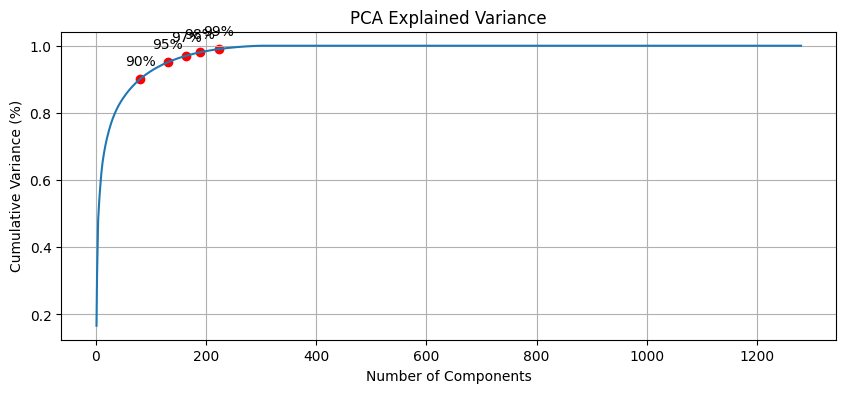

In [16]:
pca = PCA(k=num_features, inputCol="features_scaled", outputCol="pca_features")
pca_model = pca.fit(features_df)

# Calculer la variance expliquée cumulée
explained_variance_ratio = pca_model.explainedVariance.cumsum()  # Variance expliquée cumulée
components = np.arange(len(explained_variance_ratio)) + 1

# Plotting
plt.figure(figsize=(10, 4))
plt.plot(components, explained_variance_ratio, label='Cumulative Explained Variance')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Variance (%)')
plt.title('PCA Explained Variance')

# Annoter des pourcentages spécifiques de variance
variance_thresholds = [0.9, 0.95, 0.97, 0.98, 0.99]
for threshold in variance_thresholds:
    indices = np.where(explained_variance_ratio >= threshold)[0]
    if indices.size > 0:
        component_number = indices[0]
        plt.scatter(component_number + 1, explained_variance_ratio[component_number], color='red')
        plt.annotate(f"{int(threshold*100)}%", 
                     (component_number + 1, explained_variance_ratio[component_number]),
                     textcoords="offset points", xytext=(0, 10), ha='center')

plt.grid(True)
plt.show()

In [17]:
num_components_95_variance = np.where(explained_variance_ratio >= 0.95)[0][0] + 1
print(f"Number of components for 95% variance: {num_components_95_variance}")

Number of components for 95% variance: 130


In [18]:
pca_95 = PCA(k=num_components_95_variance, inputCol="features_scaled", outputCol="pca_features_95")
pca_model_95 = pca_95.fit(features_df)
features_df_pca_95 = pca_model_95.transform(features_df)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 468ms/step 1) / 1]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 436ms/step 1) / 1]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 430ms/step        
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 439ms/step1) / 20]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 420ms/step1) / 20]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 419ms/step1) / 20]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 426ms/step1) / 20]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 415ms/step1) / 20]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 402ms/step1) / 20]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 412ms/step1) / 20]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 412ms/step1) / 20]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 410ms/step1) / 20]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 409ms/step1) / 20]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 417ms/step1) / 20]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 443ms/step1) / 20]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 424ms/step1) / 20]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 426ms/step1) / 20]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 447ms/step1) / 20]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 425ms/step1) / 20]
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 513ms/step1) / 20]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 427ms/step1) / 20]
1/1 ━━━━━━━━━

In [19]:
# Save the PCA-transformed features
features_df_pca_95.write.mode("overwrite").parquet(PATH_Result + "_pca_95")

24/06/04 10:24:29 WARN DAGScheduler: Broadcasting large task binary with size 1598.2 KiB
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 415ms/step1) / 20]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 439ms/step1) / 20]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 424ms/step1) / 20]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 443ms/step1) / 20]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 452ms/step1) / 20]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 426ms/step1) / 20]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 442ms/step1) / 20]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 450ms/step1) / 20]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 414ms/step1) / 20]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 440ms/step1) / 20]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 453ms/step1) / 20]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 428ms/step1) / 20]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 430ms/step1) / 20]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 421ms/step1) / 20]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 420ms/step1) / 20]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 427ms/step1) / 20]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 424ms/step1) / 20]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 492ms/step1) / 20]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 441ms/step1) / 20]
1/1 ━━━━━━━━━━━━━━

In [20]:
features_df_pca_95.select("features").show(5)

+--------------------+
|            features|
+--------------------+
|[0.0, 0.9788637, ...|
|[0.0, 4.861076, 0...|
|[0.0, 0.6122563, ...|
|[0.0, 1.9626473, ...|
|[0.0, 4.5710754, ...|
+--------------------+
only showing top 5 rows



1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 378ms/step


In [28]:
features_df_pca_95.select("features_scaled").show(5)

+--------------------+
|     features_scaled|
+--------------------+
|[-0.2043964294633...|
|[-0.2043964294633...|
|[-0.2043964294633...|
|[-0.2043964294633...|
|[-0.2043964294633...|
+--------------------+
only showing top 5 rows



1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 375ms/step


In [29]:
features_df_pca_95.select("pca_features_95").show(5)

24/06/04 10:26:25 WARN DAGScheduler: Broadcasting large task binary with size 1378.2 KiB


+--------------------+
|     pca_features_95|
+--------------------+
|[2.05884043504070...|
|[5.00173619689516...|
|[-1.5303026876370...|
|[4.59071465401006...|
|[5.76422174329089...|
+--------------------+
only showing top 5 rows



1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 416ms/step


In [22]:
features_df_pca_95.show(5)

24/06/04 10:24:56 WARN DAGScheduler: Broadcasting large task binary with size 1386.2 KiB
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 497ms/step 1) / 1]


+--------------------+--------------+--------------------+--------------------+--------------------+--------------------+
|                path|         label|            features|     features_vector|     features_scaled|     pca_features_95|
+--------------------+--------------+--------------------+--------------------+--------------------+--------------------+
|file:/Users/m/dev...|   Cauliflower|[0.0, 0.58183247,...|[0.0,0.5818324685...|[-0.2043964294633...|[4.74919843529487...|
|file:/Users/m/dev...|Pineapple Mini|[0.0, 4.6597714, ...|[0.0,4.6597714424...|[-0.2043964294633...|[4.00097321238705...|
|file:/Users/m/dev...|   Cauliflower|[0.0, 0.7898707, ...|[0.0,0.7898706793...|[-0.2043964294633...|[4.66307818038524...|
|file:/Users/m/dev...|   Cauliflower|[0.0, 1.1880778, ...|[0.0,1.1880778074...|[-0.2043964294633...|[4.89599455546878...|
|file:/Users/m/dev...|   Cauliflower|[0.0, 0.9022645, ...|[0.0,0.9022644758...|[-0.2043964294633...|[-1.1560387400575...|
+--------------------+--

In [23]:
final_result = features_df_pca_95.select('path','label','pca_features_95')

In [24]:
final_result.toPandas().to_csv('./output/final_result.csv')

24/06/04 10:25:01 WARN DAGScheduler: Broadcasting large task binary with size 1381.4 KiB
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 417ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 402ms/step1) / 20]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 411ms/step1) / 20]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 418ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 405ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 401ms/step1) / 20]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 438ms/step1) / 20]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 423ms/step1) / 20]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 409ms/step1) / 20]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 411ms/step1) / 20]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 408ms/step1) / 20]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 401ms/step1) / 20]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 402ms/step1) / 20]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 399ms/step1) / 20]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 400ms/step1) / 20]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 397ms/step1) / 20]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 401ms/step1) / 20]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 411ms/step1) / 20]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 414ms/step1) / 20]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 406ms/step1) /

In [25]:
df_pca = spark.read.parquet(PATH_Result + "_pca_95", engine='pyarrow')

In [26]:
first_row = df_pca.first()
first_row

Row(path='file:/Users/m/dev/6be709c0/oc-ai-engineer/OC/P11/input/Test1/Cucumber Ripe/r_157_100.jpg', label='Cucumber Ripe', features=[0.8890184164047241, 0.19729341566562653, 0.0, 0.0, 0.0, 0.437781423330307, 2.9399945735931396, 0.06786995381116867, 0.01437438279390335, 0.0, 0.07110805064439774, 0.0032088998705148697, 0.00285493116825819, 0.022919712588191032, 0.05070875212550163, 0.04016406089067459, 0.0, 0.17125274240970612, 0.0, 0.04668174311518669, 0.004448287189006805, 0.013223190791904926, 0.0, 0.5756597518920898, 0.12357506155967712, 0.02788955345749855, 0.9853577613830566, 0.15024082362651825, 0.021708566695451736, 2.0433361530303955, 0.0, 0.0, 0.11274338513612747, 0.14694131910800934, 0.0, 0.48328709602355957, 1.1811329126358032, 1.4063934087753296, 1.6132478713989258, 0.005590253975242376, 0.0, 0.0, 0.5785885453224182, 0.3204052746295929, 0.6195703744888306, 0.0, 0.12178820371627808, 0.03829744830727577, 0.0, 0.19333872199058533, 0.0, 0.4866298735141754, 0.5515149235725403, 0

In [27]:
print("Avant", len(first_row["features"]))
print("Après", len(first_row["pca_features_95"]))

Avant 1280
Après 130
